In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tqdm import tqdm

In [2]:
DATADIR = "C:/Datasets/PetImages"
Categories = ["Dog","Cat"]

In [3]:
IMG_SIZE = 60
training_data = []
def create_training_data():
    # do dogs and cats
    for category in Categories:  
        # create path to dogs and cats
        path = os.path.join(DATADIR,category)  
        # get the classification  (0 or a 1). 0=dog 1=cat
        class_num = Categories.index(category)
        # iterate over each image per dogs and cats
        for img in os.listdir(path):
            try:
                # convert to array
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                # resize to normalize data size
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                training_data.append([new_array, class_num]) 
            # in the interest in keeping the output clean...
            except Exception as e:  
                pass
create_training_data()

In [4]:
print(len(training_data))

24913


In [5]:
import random
random.shuffle(training_data)

In [6]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [7]:
#normalizing X
X = X/255.0
#converting y to numpy array
y = np.array(y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=1)


In [8]:
def model_builder(hp):
    model = keras.Sequential([
    keras.layers.Conv2D(
        filters = hp.Int('conv_1_filter', min_value=32, max_value=256, step=16),
        kernel_size = hp.Choice('conv_1_kernel',values = [3,5]),
        activation='relu',
        input_shape=X.shape[1:]
    ),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(
        filters = hp.Int('conv_2_filter', min_value=32, max_value=256, step=16),
        kernel_size = hp.Choice('conv_2_kernel',values = [3,5]),
        activation='relu'
    ),
    keras.layers.Conv2D(
        filters = hp.Int('conv_3_filter', min_value=32, max_value=256, step=16),
        kernel_size = hp.Choice('conv_3_kernel',values = [3,5]),
        activation='relu'
    ),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=16),
        activation='relu'
    ),
    keras.layers.Dense(1, activation='sigmoid')
    ])
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

In [9]:
# import keras
import kerastuner as kt

In [10]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='my_dir',
                     project_name='cats_vs_dogs_kt',
                     overwrite=True)

In [11]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test,y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 08m 52s]
val_accuracy: 0.787477433681488

Best val_accuracy So Far: 0.787477433681488
Total elapsed time: 00h 43m 41s
INFO:tensorflow:Oracle triggered exit


In [13]:
#building model with best_hps
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test))

val_acc_per_epoch = history.history['val_accuracy']
#finding best epoch value based on val_accuracy
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
623/623 [==============================] - 148s 236ms/step - loss: 0.6792 - accuracy: 0.5466 - val_loss: 0.5669 - val_accuracy: 0.7086
Epoch 2/10
623/623 [==============================] - 149s 239ms/step - loss: 0.5524 - accuracy: 0.7143 - val_loss: 0.5207 - val_accuracy: 0.7493
Epoch 3/10
623/623 [==============================] - 148s 238ms/step - loss: 0.4849 - accuracy: 0.7694 - val_loss: 0.4765 - val_accuracy: 0.7672
Epoch 4/10
623/623 [==============================] - 148s 237ms/step - loss: 0.4496 - accuracy: 0.7949 - val_loss: 0.4618 - val_accuracy: 0.7807
Epoch 5/10
623/623 [==============================] - 148s 237ms/step - loss: 0.4145 - accuracy: 0.8101 - val_loss: 0.4288 - val_accuracy: 0.7985
Epoch 6/10
623/623 [==============================] - 148s 238ms/step - loss: 0.3891 - accuracy: 0.8182 - val_loss: 0.5260 - val_accuracy: 0.7502
Epoch 7/10
623/623 [==============================] - 149s 238ms/step - loss: 0.3545 - accuracy: 0.8455 - val_loss: 0.4057 -

In [16]:
#as my best epoch value is equal to total no. pf epoch value so we will use the same model

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 58, 144)       1440      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 144)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 176)       228272    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 96)        422496    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
flatten (Flatten)            (None, 11616)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

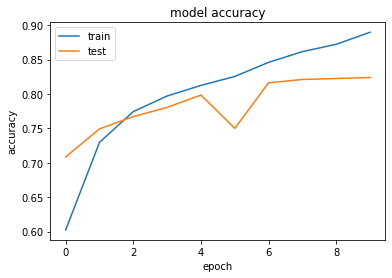

In [17]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

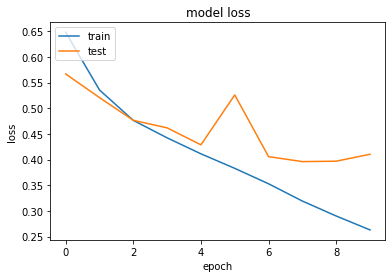

In [18]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# saving model 
#maybe model would have been better if image augmentation or ImageNet was used but it takes high computational power
model.save('CatsVsDogsUsingTuner.h5')

In [20]:
CATEGORIES = ["Dog", "Cat"]
#function to prepare input image
def prepare(filepath):
    #use this same to the size used to train the model
    IMG_SIZE = 60  
    # read in the image, convert to grayscale
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  
    # resize image to match model's expected sizing
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    # return the image with shaping that TF wants.
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  

In [21]:
#we could have imported the model but out model is presennt in the same notebook
#model = tf.keras.models.load_model("64x3-CNN.model")
#there is almost 20% chance that our model maybe wrong
prediction = model.predict([prepare('dog.jpg')])
print(CATEGORIES[int(prediction[0][0])])

Dog


In [23]:
prediction = model.predict([prepare('cat.jpg')])
print(CATEGORIES[int(prediction[0][0])])

Cat
